In [1]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
from flatten_json import flatten

# Creating the dataset and cleaned dataset
The function _data_extraction_ get the one sample case, so to build a dataset it is necessary called the function _expand_dataset_ passing two cases and the number of requested samples.

In [2]:
url = 'https://api.punkapi.com/v2/beers/random'

In [3]:
def data_extraction(url):
    response_json = requests.get(url).json()
    # json_normalize has limitations with multiple record paths
    # thus, it was necessary apply the flatten.
    dic_flattened = [flatten(d) for d in response_json]
    df = pd.json_normalize(dic_flattened, sep="_")
    return df

The dataset concatenation in _expand_dataset_is performed as follows: initially two arrays with dimension samples/2 are created and the api data are trasmnited to them. Then, these two arrays are then concatenated. This form was chosen, as it took less processing time.

In [4]:
def expand_dataset (partial_df_1, partial_df_2, samples):
    #To optimize the time, the concat will be separeted in two parts: [0, samples/2] + [0, samples/2]
    for i in range (0, int((samples-1)/2)):
        df_1 = data_extraction(url)
        partial_df_1  = pd.concat([partial_df_1, df_1], axis=0, ignore_index=False)
        df_2 = data_extraction(url)
        partial_df_2  = pd.concat([partial_df_2, df_2], axis=0, ignore_index=False)
    partial_df_1  = pd.concat([partial_df_1, partial_df_2], axis=0, ignore_index=False)
        
    return partial_df_1


In [5]:
partial_df_1 = data_extraction(url)
partial_df_2 = data_extraction(url)

In [7]:
##To refresh the dataset, please uncomment the line bellow:
df = expand_dataset(partial_df_1, partial_df_2, 1200)

##Wait three minutes to get the concat of 400 samples

The _cleaned_file_ function creates a csv file with the 'id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm' and 'ph' dataset labels

In [8]:
def cleaned_file (df): #Create a csv file with data cleaned
    df_cleaned = df.loc[:, ['id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm' ,'ph']]
    df_cleaned.to_csv('cleaned_cp2.csv', encoding='utf-8', index=False)
    return df_cleaned

In [9]:
#To refresh the csv dataset, uncomment the line bellow:
df_cleaned = cleaned_file(df)

# Reading the csv dataset and pre-processing

## Importing the dataset


In [10]:
dataset = pd.read_csv('./cleaned_cp2.csv', delimiter=',', index_col=0)

In [11]:
dataset.head()

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
id,,,,,,,,
183,Nuns With Guns,4.2,25.0,1012.0,1044.0,19.0,9.5,4.4
34,Bourbon Baby,5.8,35.0,1005.0,1049.0,44.0,22.0,4.4
321,Jinx Pale Ale,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
144,Tokyo*,16.2,85.0,1028.0,1157.0,250.0,127.0,4.4
83,Comet,7.2,70.0,1012.0,1067.0,30.0,15.0,4.4


In [12]:
dataset.shape

(1200, 8)

In [13]:
#Verifing if the label 'name' is unique
dataset["name"].value_counts().sort_index()

#Mashtag 2013            4
#Mashtag 2014            6
#Mashtag 2015            3
#Mashtag 2016            6
10 Heads High            2
                        ..
Whisky Sour - B-Sides    3
White Noise              4
Zeitgeist                1
Zephyr                   2
Zipcode                  4
Name: name, Length: 317, dtype: int64

## Label encoding

### Ordinal Encoder of 'name' label

In [14]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
dataset["name_code"] = ord_enc.fit_transform(dataset[["name"]])

In [15]:
dataset = dataset.drop(['name'], axis=1)

In [16]:
dataset.head()

,abv,ibu,target_fg,target_og,ebc,srm,ph,name_code
id,,,,,,,,
183,4.2,25.0,1012.0,1044.0,19.0,9.5,4.4,215.0
34,5.8,35.0,1005.0,1049.0,44.0,22.0,4.4,76.0
321,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6,179.0
144,16.2,85.0,1028.0,1157.0,250.0,127.0,4.4,299.0
83,7.2,70.0,1012.0,1067.0,30.0,15.0,4.4,97.0


### Checking for null data

In [17]:
dataset.isnull().sum()

abv           0
ibu          21
target_fg     3
target_og     3
ebc          18
srm          18
ph            5
name_code     0
dtype: int64

In [18]:
dataset = dataset.dropna(how='any',axis=0) 
dataset.isnull().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
name_code    0
dtype: int64

In [19]:
dataset.shape

(1169, 8)

## Analysing the correlation

In [20]:
corr = dataset.corr()
corr.style.background_gradient(cmap='cool')

,abv,ibu,target_fg,target_og,ebc,srm,ph,name_code
abv,1.000000,0.606440,0.290680,0.685980,0.421265,0.421733,0.020763,-0.109454
ibu,0.606440,1.000000,0.041460,0.232847,0.114253,0.115048,0.001853,0.088378
target_fg,0.290680,0.041460,1.000000,-0.149985,0.389561,0.389160,-0.003016,-0.084031
target_og,0.685980,0.232847,-0.149985,1.000000,0.428637,0.428911,0.044485,-0.149142
ebc,0.421265,0.114253,0.389561,0.428637,1.000000,0.999669,-0.020905,-0.087708
srm,0.421733,0.115048,0.389160,0.428911,0.999669,1.000000,-0.020751,-0.084889
ph,0.020763,0.001853,-0.003016,0.044485,-0.020905,-0.020751,1.000000,-0.072745
name_code,-0.109454,0.088378,-0.084031,-0.149142,-0.087708,-0.084889,-0.072745,1.000000


The correlation between the _srm_ and _ebc_ labels are strongly high, thus the _ebc_ label must be removed. Because it has more outliers than the other.

In [21]:
#dataset = dataset.drop(['ebc'], axis=1)
dataset.head()

,abv,ibu,target_fg,target_og,ebc,srm,ph,name_code
id,,,,,,,,
183,4.2,25.0,1012.0,1044.0,19.0,9.5,4.4,215.0
34,5.8,35.0,1005.0,1049.0,44.0,22.0,4.4,76.0
321,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6,179.0
144,16.2,85.0,1028.0,1157.0,250.0,127.0,4.4,299.0
83,7.2,70.0,1012.0,1067.0,30.0,15.0,4.4,97.0


## Boxplot analysis and outlier treatment
It is noticed the presence of many outliers in some labels

Text(0.5, 1.0, 'Outliers of non-normalized database')

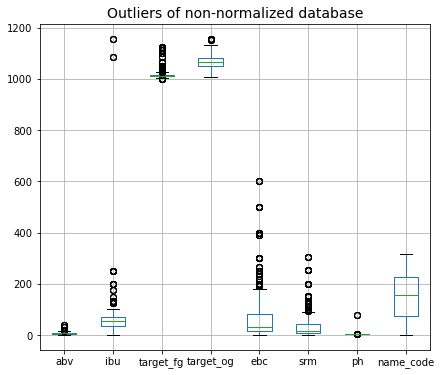

In [22]:
import matplotlib.pyplot as plt

dataset.boxplot(grid=True, figsize= (7,6))
plt.title('Outliers of non-normalized database', fontsize=14)

#### Data normalization
Because the outliers' discrepancy when compared to the median data, it was decided to use the Scaler

In [23]:
from sklearn.preprocessing import RobustScaler, StandardScaler
#! pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper

column_tuples = [
    (['name_code'], None),
    (['ibu'], None),
    (['abv'], StandardScaler()),
    (['target_fg'], StandardScaler()),
    (['target_og'], StandardScaler()),
    (['srm'], RobustScaler()),
    (['ph'], StandardScaler())
]

mapper = DataFrameMapper(column_tuples, df_out=True)
dataset = mapper.fit_transform(dataset)


Text(0.5, 1.0, 'Outliers of normalized database')

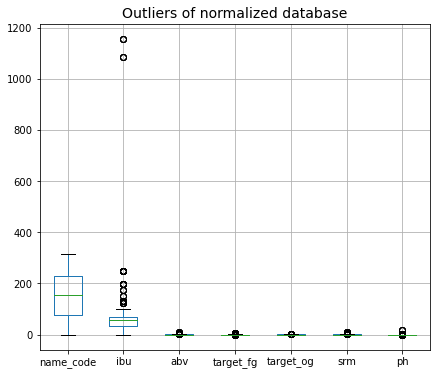

In [24]:
import matplotlib.pyplot as plt

dataset.boxplot(grid=True, figsize= (7,6))
plt.title('Outliers of normalized database', fontsize=14)

In [25]:
dataset['ibu_bin'] = ord_enc.fit_transform(dataset[["ibu"]])

### Splitting the dataset into input (x) and output (y) data
In this division the independent variables are saved in x and the dependent in y.

### Output

In [26]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(dataset["ibu_bin"])
y.shape

(1169, 51)

In [27]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
data_row, output_labels = y.shape
output_labels

51

### Input

In [29]:
dataset.columns

Index(['name_code', 'ibu', 'abv', 'target_fg', 'target_og', 'srm', 'ph',
       'ibu_bin'],
      dtype='object')

In [30]:
x = dataset.iloc[:, [0,2,3,4,6,5]].values

## Splitting the dataset in training and test 

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## ➡️ Algorithm: Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
SEED=0

In [34]:
clf = DecisionTreeClassifier(random_state = SEED)
clf_orig = DecisionTreeClassifier(random_state = SEED)

In [35]:
clf = clf.fit(X_train,y_train)

## Predição dos resultados e métricas do modelo

In [36]:
arvore_prediction = clf.predict(X_test)


### Acurácia

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
acc= accuracy_score(y_test, arvore_prediction)
acc

0.9700854700854701

### Matriz de Confusão

In [38]:
cm = confusion_matrix(y_test.argmax(axis=1), arvore_prediction.argmax(axis=1))
cm

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

In [39]:
print(classification_report(y_test, arvore_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         8
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      1.00      1.00         4
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       1.00      0.83      0.91        12
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         0
          17       0.00    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
